In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
import os
import errno
%matplotlib inline

# Choosing the model for the time series analysis

In this step several forecasting models are going to be tested. The one with the best results will be the one used to forecast future values.

### Prepare the data for the forecasting models

In [2]:
# Import the data modified
dataImport=pd.read_csv("~/Documents/Kschool/00_TFM/dataModel.csv",index_col='measure_time',parse_dates=True)

In [3]:
dataImport.head(5)

,val01_ambient_temperature,val01_ambient_winddir,val01_ambient_windspeed,val01_controller_hubtemperature,val01_controller_toptemperature,val01_electrical_activepower,val01_electrical_cosphi,val01_electrical_currentphase1,val01_electrical_currentphase2,val01_electrical_currentphase3,...,val01_meteorological_windspeed,val01_nacelle_direction,val01_nacelle_temperature,val01_rotor_bladespitchangle1,val01_rotor_hydraulicoilpressure,val01_rotor_hydraulicoiltemperature,val01_rotor_rpm,val01_rotorsystem_bladespitchangle,val01_rotorsystem_rotorrpm,val01_spinner_temperature
measure_time,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,10.75,54.699997,9.20,21.0,35.0,1605.400024,1.0,1342.599976,1349.666626,1325.666626,...,10.353333,51.038040,23.000000,-1.237798,194.024994,24.919531,14.755315,-1.758000,14.810000,12.0
2019-01-01 00:10:00,10.00,54.810001,9.50,21.0,35.0,1679.863647,1.0,1429.161255,1435.032227,1412.161255,...,10.490322,50.997501,23.000000,-0.742385,190.137497,24.898567,14.745159,-1.699000,14.880000,12.0
2019-01-01 00:20:00,10.00,53.139999,8.50,21.0,35.0,1527.050049,1.0,1298.000000,1302.000000,1280.000000,...,9.800000,54.200001,23.000000,-1.194504,190.850006,24.877604,14.735003,-1.572000,14.808248,12.0
2019-01-01 00:30:00,10.00,54.400002,8.87,21.0,35.0,1378.040039,1.0,1209.400024,1213.400024,1190.599976,...,9.153334,54.200001,23.804422,-1.403579,184.000000,24.856638,14.724848,-1.951333,14.888750,12.0
2019-01-01 00:40:00,10.00,50.920002,9.25,21.0,35.0,1315.299927,1.0,1152.000000,1155.000000,1132.000000,...,8.700000,54.200001,24.000000,-1.612653,188.937500,24.835674,14.714692,-2.133000,14.836264,12.0


Data time is moved as index and the value of the signals as float.

In [4]:
# convert the rows to data float.
for col in dataImport.columns[1:]:
    dataImport[col]=dataImport[col].apply(pd.to_numeric,errors='ignore') 
    
# convert row to datetime
dataImport.index=pd.to_datetime(dataImport.index,format="%Y-%m-%d %H:%M:%S",errors="ignore") 

To compare the models the data is divided in train and test. 

## Compare models

Ideally, we would compare the different prediction models with each of the TS clusters. However, in this case we are going to compare the different forecasting models applied to one variable (signal).

In [5]:
#select variable to test the model
dataImport_selOne=dataImport[['val01_ambient_temperature']] 

Due to the large amount of data and the computing time, we select a subset of data to compare the models.

In [6]:
#select last 500 measures for the fitting of the model
dataImport_selOne100=dataImport_selOne.iloc[-100:] 

Once variables are selected and number of data, we split the data into train and test to use in each model to compare the results.

In [7]:
# Number of test predictions
nTestPred=30 # 5 hours of prediction 6 measures/hours*5hours=30 measures
# divide the data in train and test
split_point=len(dataImport_selOne100)-nTestPred 
train, test = dataImport_selOne100[0:split_point], dataImport_selOne100[split_point:len(dataImport_selOne100)]

### Model: Auto Arima

The auto_arima function itself operates a bit like a grid search, in that it tries various sets of p and q (also P and Q for seasonal models) parameters, selecting the model that minimizes the AIC (or BIC, or whatever information criterion you select). To select the differencing terms, auto_arima uses a test of stationarity (such as an augmented Dickey-Fuller test) and seasonality (such as the Canova-Hansen test) for seasonal models. It is going to be used to get the optimal parameters.

In [8]:
# get the best parameter for the existing data, the one with lowest AIC
# EXECUTING TIME 24 sec
autoArimaModel = auto_arima(dataImport_selOne100, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(autoArimaModel.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=156.900, BIC=169.230, Fit time=1.199 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=178.271, BIC=183.202, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=171.791, BIC=181.654, Fit time=0.256 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=154.947, BIC=164.810, Fit time=0.642 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=154.341, BIC=166.671, Fit time=0.918 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=171.890, BIC=181.753, Fit time=0.248 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=176.665, BIC=184.062, Fit time=0.103 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=156.2

In [9]:
# Optimal order parameter
autoArimaModel.order

(0, 1, 0)

In [10]:
# Optimal seasonal order parameter
autoArimaModel.seasonal_order

(2, 1, 1, 12)

In [11]:
# Now that we have the model parameters, lets fit the model with train data
autoArimaModel.fit(train)

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(0, 1, 0),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 1, 1, 12), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

In [12]:
# Once it is trained, let's create the prediction
future_forecast=pd.DataFrame(autoArimaModel.predict(n_periods=nTestPred),index=test.index)
future_forecast.columns=['predicted']

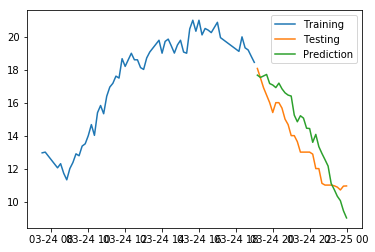

In [13]:
# Plot prediction forecast matched up with the test set for which we have the real data
pyplot.plot(train,label='Training')
pyplot.plot(test,label='Testing')
pyplot.plot(future_forecast,label='Prediction')
pyplot.legend(loc='upper right')
pyplot.show()

In [14]:
# Calculate the error in the prediction
test['predicted']=future_forecast
test['error']=test['val01_ambient_temperature']-test['predicted']
test

/Users/juanfatri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/juanfatri/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,val01_ambient_temperature,predicted,error
measure_time,,,
2019-03-24 19:10:00,18.074692,17.669327,0.405365
2019-03-24 19:20:00,17.501041,17.530339,-0.029297
2019-03-24 19:30:00,16.909849,17.619847,-0.709997
2019-03-24 19:40:00,16.455303,17.711132,-1.255829
2019-03-24 19:50:00,16.000757,17.159339,-1.158582
2019-03-24 20:00:00,15.402000,17.071396,-1.669395
2019-03-24 20:10:00,16.000000,16.914253,-0.914253
2019-03-24 20:20:00,16.000000,17.185507,-1.185507
2019-03-24 20:30:00,15.670000,16.840243,-1.170243


In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Evaluate the prediction calculating rmse
rmse = sqrt(mean_squared_error(test.val01_ambient_temperature,test.predicted))
print(rmse)


1.392140215384274


### Other models to consider
#### Facebook Prophet, Moving average, etc...

# Forecasting model

Once the optimal model has been selected, it is time to predict future values of multiple signals. Ideally, we should use the TS cluster and forecast using the optimal parameters for the group. TS cluster is left for future implementations. 

Selected three signals to forecast future values.

## Function for the Time Series Forecast

In [20]:
#Functions
def autoArimaModelVar(dataModel,dataTotal,dataTotalCopy,counter1): #make predictions
    model = auto_arima(dataModel, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    
    # Forecast
    n_periods = 6 # 1 hour
    index_of_fc = pd.date_range(dataTotal.index[-1], periods = n_periods, freq='10min')
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    fc1=pd.DataFrame(fc,index=index_of_fc) 
    confint1=pd.DataFrame(confint,index=index_of_fc) 
    fc1.columns=['Predicted']
    confint1.columns=['LowerConfidenceInterval','UpperConfidenceInterval']
    
    # Store the forecast values in the dataFrame
    forecastValues=fc1 # predicted value
    forecastValues['LowerConfidenceInterval']=confint1['LowerConfidenceInterval'] #lower confidence interval
    forecastValues['UpperConfidenceInterval']=confint1['UpperConfidenceInterval'] #upper confidence interval

    # calculate new variables
    #forecastValues['error']=forecastValues['val01_ambient_temperature']-forecastValues['Predicted'] #when we have values
    forecastValues['std_dev']=forecastValues['UpperConfidenceInterval']-forecastValues['Predicted']
    forecastValues = forecastValues.loc[~forecastValues.index.duplicated(keep='first')] #indexes must be unique for concat
    
    # Create a column with the value of the measures
    valueCol=dataTotalCopy #  
    valueCol = valueCol.loc[~valueCol.index.duplicated(keep='first')] #indexes must be unique for concat
    
    # Concatenate using the index, the values and the forecast
    frames=[valueCol,forecastValues]
    result=pd.concat(frames,axis=1)
    #result=pd.join(frames)
    result.tail(10)

    # Add a column called signal with the name of the signal preparing for the long format, instead of wide.
    result['signal']=pd.DataFrame(dataTotal).columns[0]
    
    # Naming column "value" with all the measured values 
    result['value']=pd.DataFrame(valueCol)
    
    #
    result = result.rename_axis('measure_time')

    #delete all the NaN after the concatenate
    resultNoNaN = result.replace(np.nan, '', regex=True)

    
    
    return resultNoNaN

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=156.900, BIC=169.230, Fit time=0.965 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=178.271, BIC=183.202, Fit time=0.056 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=171.791, BIC=181.654, Fit time=0.253 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=154.947, BIC=164.810, Fit time=0.605 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=154.341, BIC=166.671, Fit time=0.950 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=171.890, BIC=181.753, Fit time=0.207 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=176.665, BIC=184.062, Fit time=0.095 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(2, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=156.2

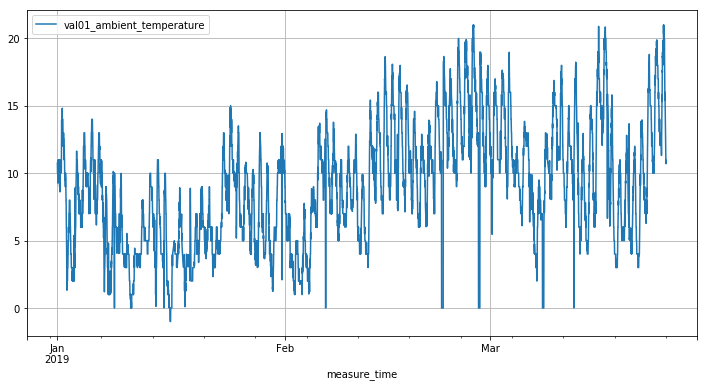

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=763.267, BIC=775.596, Fit time=1.060 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=814.119, BIC=819.051, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=772.263, BIC=782.127, Fit time=0.459 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=761.271, BIC=771.135, Fit time=0.612 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=762.722, BIC=775.051, Fit time=0.867 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=806.297, BIC=813.695, Fit time=0.128 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=768.541, BIC=775.939, Fit time=0.356 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=763.2

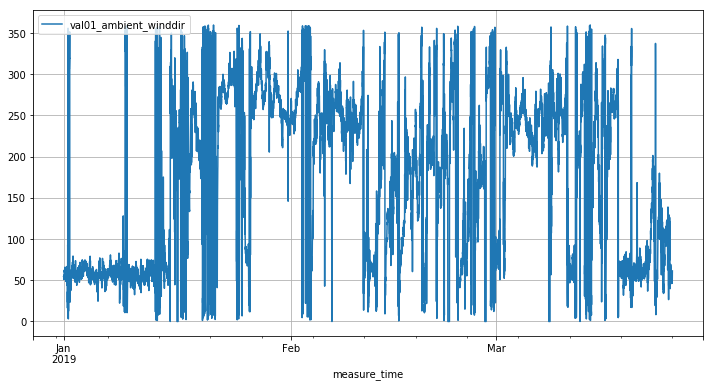

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=303.112, BIC=315.442, Fit time=0.484 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=354.568, BIC=359.500, Fit time=0.021 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=320.468, BIC=330.332, Fit time=0.193 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=303.049, BIC=312.913, Fit time=0.603 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=305.033, BIC=317.362, Fit time=0.602 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=339.890, BIC=347.288, Fit time=0.070 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 12); AIC=318.957, BIC=326.354, Fit time=0.268 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 12); AIC=299.7

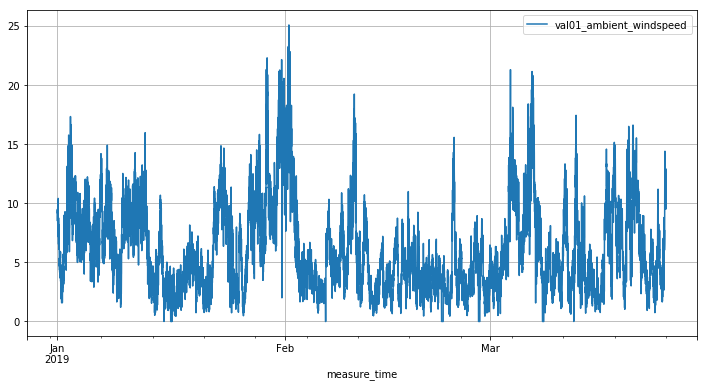

In [36]:
#select various columns to test the model
dataImport_selVar=dataImport[['val01_ambient_temperature','val01_ambient_winddir','val01_ambient_windspeed']] 

#select last 100 measures for the fitting of the model
dataImport_selVar100=dataImport_selVar.iloc[-100:] #select 100 hundred from the last 101 measures for training.

#create a variable to prevent original data to corrupt
dataImport_selVar_copy=dataImport_selVar 

# Initialize counter for the for loop to move along the columns (signals)
counterTest=0

for column in dataImport_selVar100:
    if counterTest==0: #initialize
        result01=autoArimaModelVar(dataImport_selVar100[column],dataImport_selVar[column],
                             dataImport_selVar_copy[column],counterTest)
    else:
        result11=autoArimaModelVar(dataImport_selVar100[column],dataImport_selVar[column],
                             dataImport_selVar_copy[column],counterTest)
        result01=result01.append(result11,sort=False) #print only 18
     

    # Plot
    dataImport_selVar[column].plot(figsize=(12,6),legend=True)
    #result01NoNaN['value']=result01NoNaN['value'].astype(float)
    #result01NoNaN['value'].plot(legend=True)
    pyplot.grid(True)
    pyplot.show();
    
    counterTest +=1


# change the name of the NaN to "" preparing the output for Tableau.
result01NoNaN = result01.replace(np.nan, '', regex=True)

#
result01NoNaN['windTurbine']=result01NoNaN['signal'].str[:5]

# Export the output ready for Tableau
export_csv=result01NoNaN.to_csv('/Users/juanfatri/Documents/Kschool/00_TFM/result01NoNaN.csv',index=True, header=True)

In [18]:
result01NoNaN.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35874 entries, 2019-01-01 00:00:00 to 2019-03-25 00:50:00
Data columns (total 10 columns):
val01_ambient_temperature    35874 non-null object
Predicted                    35874 non-null object
LowerConfidenceInterval      35874 non-null object
UpperConfidenceInterval      35874 non-null object
std_dev                      35874 non-null object
signal                       35874 non-null object
value                        35874 non-null object
val01_ambient_winddir        35874 non-null object
val01_ambient_windspeed      35874 non-null object
windTurbine                  35874 non-null object
dtypes: object(10)
memory usage: 3.0+ MB


In [19]:
result01NoNaN

,val01_ambient_temperature,Predicted,LowerConfidenceInterval,UpperConfidenceInterval,std_dev,signal,value,val01_ambient_winddir,val01_ambient_windspeed,windTurbine
measure_time,,,,,,,,,,
2019-01-01 00:00:00,10.75,,,,,val01_ambient_temperature,10.75,,,val01
2019-01-01 00:10:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 00:20:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 00:30:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 00:40:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 00:50:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 01:00:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 01:10:00,10,,,,,val01_ambient_temperature,10,,,val01
2019-01-01 01:20:00,10,,,,,val01_ambient_temperature,10,,,val01


## Google Research Colab

Since computing time using Auto Arima are really high, and TS clustering will be considered for future developments, alternatively, I have tried with google colab. However I got errors that were not possible to solve in the time being.
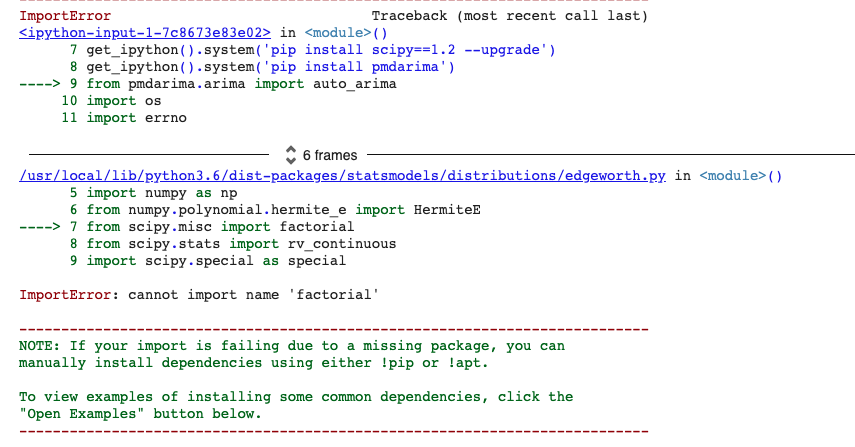

## Updating the model

As new data comes to the Time Series the model needs to keep updating the forecast.

In [34]:
# XXX--- This code is not refined just a draft ----XXX
# Now add the actual samples to the model and create NEW forecasts
model.update(test)
new_preds, new_conf_int = arima.predict(n_periods=10, return_conf_int=True)
new_x_axis = np.arange(data.shape[0] + 10)

axes[1].plot(new_x_axis[:data.shape[0]], data, alpha=0.75)
axes[1].scatter(new_x_axis[data.shape[0]:], new_preds, alpha=0.4, marker='o')
axes[1].fill_between(new_x_axis[-new_preds.shape[0]:],
                     new_conf_int[:, 0],
                     new_conf_int[:, 1],
                     alpha=0.1, color='g')
axes[1].set_title("Added new observed values with new forecasts")
plt.show()

NameError: name 'model' is not defined